# transfer learning resnet50->cifar10

## plan
1. save resnet50 models for every 20 epoch
2. save the training and testing dataset(gap layer data)
3. reuse autoencoder for each snapshot,get the low dimension representation
4. after we get the high dimension data and low dimension data, compare the distance between them
5. print the result for each snapshot and draw a demo for it


### save resnet50 for every 20 epoch
Resnet v1:[Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)
copy from [keras tutorials](https://keras.io/zh/examples/cifar10_resnet/)

In [23]:
# load modules
from __future__ import print_function
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import tensorflow as tf
import numpy as np
import os
import math

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 9

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
# we only consider v1 here
version = 1

# Computed depth from supplied model parameter n
depth = n * 6 + 2
# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)
print("model_type:", model_type)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

model_type: ResNet56v1
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [3]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [4]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tf.keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [5]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
________________________________________________________________________

In [6]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'resnet_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=False,
                             save_weights_only=False, mode='auto',
                             save_freq="epoch",
                             period=10)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
tb = tf.keras.callbacks.TensorBoard(log_dir='logs/resnet56/',histogram_freq=1)

callbacks = [checkpoint, lr_reducer, lr_scheduler, tb]

In [7]:
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

Using real-time data augmentation.


C:\Users\xianglin\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
Learning rate:  0.001
1563/1563 [==============================] - 118s 72ms/step - loss: 2.2836 - accuracy: 0.3736 - val_loss: 1.6730 - val_accuracy: 0.5326
Epoch 2/200
Learning rate:  0.001
1563/1563 [==============================] - 111s 71ms/step - loss: 1.4910 - accuracy: 0.5997 - val_loss: 1.3492 - val_accuracy: 0.6424
Epoch 3/200
Learning rate:  0.001
1563/1563 [==============================] - 111s 71ms/step - loss: 1.2298 - accuracy: 0.6857 - val_loss: 1.6395 - val_accuracy: 0.6017
Epoch 4/200
Learning rate:  0.001
1563/1563 [==============================] - 110s 70ms/step - loss: 1.1019 - accuracy: 0.7213 - val_loss: 1.9591 - val_accuracy: 0.5788
Epoch 5/200
Learning rate:  0.001
1563/1563 [==============================] - 110s 71ms/step - loss: 1.0170 - accuracy: 0.7474 - val_loss: 1.1693 - val_accuracy: 0.6987
Epoch 6/200
Learning rate:  0.001
1563/1563 [==============================] - 111s 71ms/step - loss: 0.9510 - accuracy: 0.7722 - val_loss: 1.5962 - v

1563/1563 [==============================] - 114s 73ms/step - loss: 0.5371 - accuracy: 0.8958 - val_loss: 0.7220 - val_accuracy: 0.8400
Epoch 47/200
Learning rate:  0.001
1563/1563 [==============================] - 114s 73ms/step - loss: 0.5376 - accuracy: 0.8955 - val_loss: 0.7444 - val_accuracy: 0.8351
Epoch 48/200
Learning rate:  0.001
1563/1563 [==============================] - 113s 72ms/step - loss: 0.5331 - accuracy: 0.8951 - val_loss: 0.6954 - val_accuracy: 0.8492
Epoch 49/200
Learning rate:  0.001
1563/1563 [==============================] - 114s 73ms/step - loss: 0.5293 - accuracy: 0.8950 - val_loss: 0.8448 - val_accuracy: 0.8132
Epoch 50/200
Learning rate:  0.001
1563/1563 [==============================] - 113s 72ms/step - loss: 0.5223 - accuracy: 0.8998 - val_loss: 0.6930 - val_accuracy: 0.8493

Epoch 00050: saving model to D:\xianglin\git_space\DeepVisualInsight\DeepView\resnet_models\cifar10_ResNet56v1_model.050.h5
Epoch 51/200
Learning rate:  0.001
1563/1563 [=========

Epoch 91/200
Learning rate:  0.0001
1563/1563 [==============================] - 116s 74ms/step - loss: 0.2859 - accuracy: 0.9652 - val_loss: 0.4490 - val_accuracy: 0.9155
Epoch 92/200
Learning rate:  0.0001
1563/1563 [==============================] - 116s 74ms/step - loss: 0.2785 - accuracy: 0.9656 - val_loss: 0.4524 - val_accuracy: 0.9145
Epoch 93/200
Learning rate:  0.0001
1563/1563 [==============================] - 116s 74ms/step - loss: 0.2725 - accuracy: 0.9679 - val_loss: 0.4438 - val_accuracy: 0.9161
Epoch 94/200
Learning rate:  0.0001
1563/1563 [==============================] - 117s 75ms/step - loss: 0.2642 - accuracy: 0.9701 - val_loss: 0.4392 - val_accuracy: 0.9158
Epoch 95/200
Learning rate:  0.0001
1563/1563 [==============================] - 114s 73ms/step - loss: 0.2660 - accuracy: 0.9669 - val_loss: 0.4420 - val_accuracy: 0.9170
Epoch 96/200
Learning rate:  0.0001
1563/1563 [==============================] - 115s 74ms/step - loss: 0.2576 - accuracy: 0.9698 - val_loss

1563/1563 [==============================] - 103s 66ms/step - loss: 0.1494 - accuracy: 0.9915 - val_loss: 0.4422 - val_accuracy: 0.9206
Epoch 180/200
Learning rate:  1e-06
1563/1563 [==============================] - 100s 64ms/step - loss: 0.1523 - accuracy: 0.9903 - val_loss: 0.4420 - val_accuracy: 0.9201

Epoch 00180: saving model to D:\xianglin\git_space\DeepVisualInsight\DeepView\resnet_models\cifar10_ResNet56v1_model.180.h5
Epoch 181/200
Learning rate:  1e-06
1563/1563 [==============================] - 107s 69ms/step - loss: 0.1505 - accuracy: 0.9917 - val_loss: 0.4450 - val_accuracy: 0.9200
Epoch 182/200
Learning rate:  5e-07
1563/1563 [==============================] - 103s 66ms/step - loss: 0.1499 - accuracy: 0.9911 - val_loss: 0.4429 - val_accuracy: 0.9205
Epoch 183/200
Learning rate:  5e-07
1563/1563 [==============================] - 98s 63ms/step - loss: 0.1507 - accuracy: 0.9905 - val_loss: 0.4466 - val_accuracy: 0.9201
Epoch 184/200
Learning rate:  5e-07
1563/1563 [=====

In [8]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 6s 20ms/step - loss: 0.4449 - accuracy: 0.9204
Test loss: 0.4448535740375519
Test accuracy: 0.9204000234603882


## save the training and testing dataset(gap layer data)

In [11]:
# Prepare model model loading directory.
load_dir = os.path.join(os.getcwd(), 'resnet_models')
n_epoches=np.arange(10,210,10)
print(n_epoches)

batch_size = 1000

save_dir = os.path.join(os.getcwd(),'high_output')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

for n_epoch in n_epoches:
    model_name = 'cifar10_ResNet56v1_model.{:03d}.h5'.format(n_epoch)
    modelpath = os.path.join(load_dir, model_name)
    
    load_model = tf.keras.models.load_model(modelpath)
    model_gap = Model(inputs=load_model.input,outputs=load_model.get_layer('flatten').output)
    
    train_output = np.zeros((50000,64))
    n_batches = max(math.ceil(len(x_train) / batch_size), 1)
    for b in range(n_batches):
        r1, r2 = b * batch_size, (b + 1) * batch_size
        inputs = x_train[r1:r2]
        outputs = model_gap(inputs)
        train_output[r1:r2] = outputs
    filepath = os.path.join(save_dir,"train_{:03d}.npy".format(n_epoch))
    np.save(filepath, train_output)
    
    test_output = np.zeros((10000,64))
    n_batches = max(math.ceil(len(x_test) / batch_size), 1)
    for b in range(n_batches):
        r1, r2 = b * batch_size, (b + 1) * batch_size
        inputs = x_test[r1:r2]
        outputs = model_gap(inputs)
        test_output[r1:r2] = outputs
    filepath = os.path.join(save_dir,"test_{:03d}.npy".format(n_epoch))
    np.save(filepath, test_output)
    print("Finish {:03d} epoch...".format(n_epoch))

[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200]
Finish 010 epoch...
Finish 020 epoch...
Finish 030 epoch...
Finish 040 epoch...
Finish 050 epoch...
Finish 060 epoch...
Finish 070 epoch...
Finish 080 epoch...
Finish 090 epoch...
Finish 100 epoch...
Finish 110 epoch...
Finish 120 epoch...
Finish 130 epoch...
Finish 140 epoch...
Finish 150 epoch...
Finish 160 epoch...
Finish 170 epoch...
Finish 180 epoch...
Finish 190 epoch...
Finish 200 epoch...


## reuse autoencoder for each snapshot,get the low dimension representation

In [12]:
from parametric_umap import ParametricUMAP

In [13]:
# define encoder
dims = (64,)
n_components = 2
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 3,202
Trainable params: 3,202
Non-trainable params: 0
_________________________________________________________________


In [14]:
# define the decoder
decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_components)),
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=np.product(dims), name="recon", activation=None),
    tf.keras.layers.Reshape(dims),

])
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
recon (Dense)                (None, 64)                2112      
_________________________________________________________________
reshape (Reshape)            (None, 64)                0         
Total params: 3,264
Trainable params: 3,264
Non-trainable params: 0
_________________________________________________________________


In [15]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 5:
        lr *= 1e-1
    elif epoch > 15:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

keras_fit_kwargs = {"callbacks": [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        min_delta=10**-2,
        patience=10,
        verbose=1,
    ),
    tf.keras.callbacks.TensorBoard(log_dir='logs/mse/',histogram_freq=1),
#     tf.keras.callbacks.LearningRateScheduler(lr_schedule),
#     tf.keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
#                                cooldown=0,
#                                patience=5,
#                                min_lr=0.5e-6)
]}

In [16]:
embedder = ParametricUMAP(
    encoder=encoder,
    decoder=decoder,
    dims=dims,
    parametric_reconstruction=True,
    optimizer = tf.keras.optimizers.Adam(1e-3),
#     reconstruction_validation=validation_data,
    autoencoder_loss=True,
    n_training_epochs=100,
    keras_fit_kwargs = keras_fit_kwargs,
    verbose=True,
)

## print the result for each snapshot and draw a demo for it

ParametricUMAP(autoencoder_loss=True,
               decoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x00000247DFF52518>,
               dims=(64,),
               encoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x00000247DFF81CF8>,
               keras_fit_kwargs={'callbacks': [<tensorflow.python.keras.callbacks.EarlyStopping object at 0x00000247E0FAE390>,
                                               <tensorflow.python.keras.callbacks.TensorBoard object at 0x00000247E0FAEDA0>]},
               n_training_epochs=100,
               optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x00000247DFFBBB38>,
               parametric_reconstruction=True)
Construct fuzzy simplicial set
Thu Dec 17 00:29:37 2020 Finding Nearest Neighbors
Thu Dec 17 00:29:37 2020 Building RP forest with 16 trees
Thu Dec 17 00:29:38 2020 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting aft

D:\xianglin\git_space\DeepVisualInsight\DeepView\parametric_umap.py:268: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  "Data should be scaled to the range 0-1 for cross-entropy reconstruction loss."


Epoch 1/1000
612/612 [==============================] - 6s 9ms/step - loss: 2.3267 - reconstruction_loss: 2.0260 - umap_loss: 0.3007
Epoch 2/1000
612/612 [==============================] - 4s 7ms/step - loss: 0.7633 - reconstruction_loss: 0.5487 - umap_loss: 0.2146
Epoch 3/1000
612/612 [==============================] - 5s 8ms/step - loss: 0.6802 - reconstruction_loss: 0.4785 - umap_loss: 0.2017
Epoch 4/1000
612/612 [==============================] - 5s 8ms/step - loss: 0.6139 - reconstruction_loss: 0.4196 - umap_loss: 0.1943
Epoch 5/1000
612/612 [==============================] - 5s 7ms/step - loss: 0.5867 - reconstruction_loss: 0.3973 - umap_loss: 0.1894
Epoch 6/1000
612/612 [==============================] - 5s 8ms/step - loss: 0.5683 - reconstruction_loss: 0.3810 - umap_loss: 0.1873
Epoch 7/1000
612/612 [==============================] - 5s 7ms/step - loss: 0.5533 - reconstruction_loss: 0.3680 - umap_loss: 0.1853
Epoch 8/1000
612/612 [==============================] - 5s 7ms/step -

	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Thu Dec 17 00:33:09 2020 Finished Nearest Neighbor Search
Thu Dec 17 00:33:10 2020 Construct embedding


D:\xianglin\git_space\DeepVisualInsight\DeepView\parametric_umap.py:268: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  "Data should be scaled to the range 0-1 for cross-entropy reconstruction loss."


Epoch 1/1000
620/620 [==============================] - 7s 10ms/step - loss: 0.4961 - reconstruction_loss: 0.3165 - umap_loss: 0.1796
Epoch 2/1000
620/620 [==============================] - 6s 9ms/step - loss: 0.4527 - reconstruction_loss: 0.2786 - umap_loss: 0.1740
Epoch 3/1000
620/620 [==============================] - 5s 9ms/step - loss: 0.4494 - reconstruction_loss: 0.2760 - umap_loss: 0.1734
Epoch 4/1000
620/620 [==============================] - 6s 9ms/step - loss: 0.4469 - reconstruction_loss: 0.2744 - umap_loss: 0.1725
Epoch 5/1000
620/620 [==============================] - 6s 9ms/step - loss: 0.4451 - reconstruction_loss: 0.2728 - umap_loss: 0.1723
Epoch 6/1000
620/620 [==============================] - 6s 9ms/step - loss: 0.4434 - reconstruction_loss: 0.2718 - umap_loss: 0.1716
Epoch 7/1000
620/620 [==============================] - 6s 9ms/step - loss: 0.4427 - reconstruction_loss: 0.2712 - umap_loss: 0.1716A: 1s - loss: 0.4429 - reconstructio
Epoch 8/1000
620/620 [==========

D:\xianglin\git_space\DeepVisualInsight\DeepView\parametric_umap.py:268: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  "Data should be scaled to the range 0-1 for cross-entropy reconstruction loss."


Epoch 1/1000
626/626 [==============================] - 6s 9ms/step - loss: 0.4206 - reconstruction_loss: 0.2403 - umap_loss: 0.1803
Epoch 2/1000
626/626 [==============================] - 5s 8ms/step - loss: 0.3874 - reconstruction_loss: 0.2127 - umap_loss: 0.1747
Epoch 3/1000
626/626 [==============================] - 5s 8ms/step - loss: 0.3838 - reconstruction_loss: 0.2104 - umap_loss: 0.1734
Epoch 4/1000
626/626 [==============================] - 5s 8ms/step - loss: 0.3812 - reconstruction_loss: 0.2090 - umap_loss: 0.1722
Epoch 5/1000
626/626 [==============================] - 5s 8ms/step - loss: 0.3800 - reconstruction_loss: 0.2081 - umap_loss: 0.1720
Epoch 6/1000
626/626 [==============================] - 5s 8ms/step - loss: 0.3787 - reconstruction_loss: 0.2073 - umap_loss: 0.1714
Epoch 7/1000
626/626 [==============================] - 5s 8ms/step - loss: 0.3779 - reconstruction_loss: 0.2068 - umap_loss: 0.1711
Epoch 8/1000
626/626 [==============================] - 5s 8ms/step -

D:\xianglin\git_space\DeepVisualInsight\DeepView\parametric_umap.py:268: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  "Data should be scaled to the range 0-1 for cross-entropy reconstruction loss."


Epoch 1/1000
633/633 [==============================] - 7s 10ms/step - loss: 0.3922 - reconstruction_loss: 0.2085 - umap_loss: 0.1837
Epoch 2/1000
633/633 [==============================] - 6s 9ms/step - loss: 0.3696 - reconstruction_loss: 0.1927 - umap_loss: 0.1769
Epoch 3/1000
633/633 [==============================] - 6s 9ms/step - loss: 0.3674 - reconstruction_loss: 0.1911 - umap_loss: 0.1763
Epoch 4/1000
633/633 [==============================] - 6s 9ms/step - loss: 0.3654 - reconstruction_loss: 0.1901 - umap_loss: 0.1753A: 1s - loss: 0.3655 - reconstruction_loss: 0.1902
Epoch 5/1000
633/633 [==============================] - 6s 10ms/step - loss: 0.3634 - reconstruction_loss: 0.1887 - umap_loss: 0.1747
Epoch 6/1000
633/633 [==============================] - 6s 9ms/step - loss: 0.3629 - reconstruction_loss: 0.1888 - umap_loss: 0.1741
Epoch 7/1000
633/633 [==============================] - 6s 9ms/step - loss: 0.3619 - reconstruction_loss: 0.1882 - umap_loss: 0.1736
Epoch 8/1000
633/

D:\xianglin\git_space\DeepVisualInsight\DeepView\parametric_umap.py:268: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  "Data should be scaled to the range 0-1 for cross-entropy reconstruction loss."


Epoch 1/1000
635/635 [==============================] - 7s 10ms/step - loss: 0.3472 - reconstruction_loss: 0.1714 - umap_loss: 0.1758
Epoch 2/1000
635/635 [==============================] - 6s 9ms/step - loss: 0.3268 - reconstruction_loss: 0.1568 - umap_loss: 0.1700
Epoch 3/1000
635/635 [==============================] - 6s 10ms/step - loss: 0.3249 - reconstruction_loss: 0.1552 - umap_loss: 0.1697
Epoch 4/1000
635/635 [==============================] - 6s 9ms/step - loss: 0.3231 - reconstruction_loss: 0.1542 - umap_loss: 0.1689
Epoch 5/1000
635/635 [==============================] - 6s 9ms/step - loss: 0.3219 - reconstruction_loss: 0.1538 - umap_loss: 0.1681
Epoch 6/1000
635/635 [==============================] - 6s 9ms/step - loss: 0.3216 - reconstruction_loss: 0.1536 - umap_loss: 0.1681
Epoch 7/1000
635/635 [==============================] - 5s 8ms/step - loss: 0.3208 - reconstruction_loss: 0.1533 - umap_loss: 0.1675
Epoch 8/1000
635/635 [==============================] - 6s 9ms/step

D:\xianglin\git_space\DeepVisualInsight\DeepView\parametric_umap.py:268: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  "Data should be scaled to the range 0-1 for cross-entropy reconstruction loss."


Epoch 1/1000
633/633 [==============================] - 6s 9ms/step - loss: 0.3321 - reconstruction_loss: 0.1635 - umap_loss: 0.1686
Epoch 2/1000
633/633 [==============================] - 5s 8ms/step - loss: 0.3181 - reconstruction_loss: 0.1539 - umap_loss: 0.1642
Epoch 3/1000
633/633 [==============================] - 5s 8ms/step - loss: 0.3160 - reconstruction_loss: 0.1526 - umap_loss: 0.1635
Epoch 4/1000
633/633 [==============================] - 5s 7ms/step - loss: 0.3151 - reconstruction_loss: 0.1521 - umap_loss: 0.1630
Epoch 5/1000
633/633 [==============================] - 5s 8ms/step - loss: 0.3134 - reconstruction_loss: 0.1513 - umap_loss: 0.1621
Epoch 6/1000
633/633 [==============================] - 5s 8ms/step - loss: 0.3124 - reconstruction_loss: 0.1508 - umap_loss: 0.1616
Epoch 7/1000
633/633 [==============================] - 5s 7ms/step - loss: 0.3129 - reconstruction_loss: 0.1507 - umap_loss: 0.1622
Epoch 8/1000
633/633 [==============================] - 5s 8ms/step -

D:\xianglin\git_space\DeepVisualInsight\DeepView\parametric_umap.py:268: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  "Data should be scaled to the range 0-1 for cross-entropy reconstruction loss."


Epoch 1/1000
646/646 [==============================] - 7s 10ms/step - loss: 0.3018 - reconstruction_loss: 0.1294 - umap_loss: 0.1724
Epoch 2/1000
646/646 [==============================] - 6s 9ms/step - loss: 0.2912 - reconstruction_loss: 0.1218 - umap_loss: 0.1694
Epoch 3/1000
646/646 [==============================] - 6s 9ms/step - loss: 0.2884 - reconstruction_loss: 0.1205 - umap_loss: 0.1679A:
Epoch 4/1000
646/646 [==============================] - 6s 9ms/step - loss: 0.2865 - reconstruction_loss: 0.1197 - umap_loss: 0.1668
Epoch 5/1000
646/646 [==============================] - 6s 9ms/step - loss: 0.2858 - reconstruction_loss: 0.1194 - umap_loss: 0.1664
Epoch 6/1000
646/646 [==============================] - 6s 9ms/step - loss: 0.2856 - reconstruction_loss: 0.1192 - umap_loss: 0.1664
Epoch 7/1000
646/646 [==============================] - 6s 9ms/step - loss: 0.2850 - reconstruction_loss: 0.1190 - umap_loss: 0.1660
Epoch 8/1000
646/646 [==============================] - 6s 9ms/ste

D:\xianglin\git_space\DeepVisualInsight\DeepView\parametric_umap.py:268: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  "Data should be scaled to the range 0-1 for cross-entropy reconstruction loss."


Epoch 1/1000
637/637 [==============================] - 6s 9ms/step - loss: 0.3013 - reconstruction_loss: 0.1241 - umap_loss: 0.1771
Epoch 2/1000
637/637 [==============================] - 5s 8ms/step - loss: 0.2916 - reconstruction_loss: 0.1182 - umap_loss: 0.1733
Epoch 3/1000
637/637 [==============================] - 5s 7ms/step - loss: 0.2897 - reconstruction_loss: 0.1174 - umap_loss: 0.1723
Epoch 4/1000
637/637 [==============================] - 5s 8ms/step - loss: 0.2894 - reconstruction_loss: 0.1170 - umap_loss: 0.1723A: 2s - loss: 0.2897 - r
Epoch 5/1000
637/637 [==============================] - 5s 8ms/step - loss: 0.2892 - reconstruction_loss: 0.1168 - umap_loss: 0.1723
Epoch 6/1000
637/637 [==============================] - 5s 8ms/step - loss: 0.2882 - reconstruction_loss: 0.1166 - umap_loss: 0.1716
Epoch 7/1000
637/637 [==============================] - 5s 8ms/step - loss: 0.2879 - reconstruction_loss: 0.1161 - umap_loss: 0.1718
Epoch 8/1000
637/637 [=======================

D:\xianglin\git_space\DeepVisualInsight\DeepView\parametric_umap.py:268: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  "Data should be scaled to the range 0-1 for cross-entropy reconstruction loss."


Epoch 1/1000
644/644 [==============================] - 7s 10ms/step - loss: 0.3084 - reconstruction_loss: 0.1537 - umap_loss: 0.1547
Epoch 2/1000
644/644 [==============================] - 6s 9ms/step - loss: 0.3001 - reconstruction_loss: 0.1481 - umap_loss: 0.1520A: 2s - loss: 0.3004
Epoch 3/1000
644/644 [==============================] - 6s 9ms/step - loss: 0.2985 - reconstruction_loss: 0.1473 - umap_loss: 0.1513
Epoch 4/1000
644/644 [==============================] - 6s 9ms/step - loss: 0.2980 - reconstruction_loss: 0.1470 - umap_loss: 0.1510
Epoch 5/1000
644/644 [==============================] - 6s 9ms/step - loss: 0.2960 - reconstruction_loss: 0.1461 - umap_loss: 0.1499
Epoch 6/1000
644/644 [==============================] - 6s 9ms/step - loss: 0.2965 - reconstruction_loss: 0.1462 - umap_loss: 0.1503
Epoch 7/1000
644/644 [==============================] - 6s 9ms/step - loss: 0.2957 - reconstruction_loss: 0.1458 - umap_loss: 0.1499
Epoch 8/1000
644/644 [==========================

D:\xianglin\git_space\DeepVisualInsight\DeepView\parametric_umap.py:268: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  "Data should be scaled to the range 0-1 for cross-entropy reconstruction loss."


Epoch 1/1000
650/650 [==============================] - 7s 10ms/step - loss: 0.3154 - reconstruction_loss: 0.1656 - umap_loss: 0.1497
Epoch 2/1000
650/650 [==============================] - 6s 9ms/step - loss: 0.3120 - reconstruction_loss: 0.1642 - umap_loss: 0.1478
Epoch 3/1000
650/650 [==============================] - 6s 9ms/step - loss: 0.3120 - reconstruction_loss: 0.1638 - umap_loss: 0.1483
Epoch 4/1000
650/650 [==============================] - 6s 9ms/step - loss: 0.3116 - reconstruction_loss: 0.1636 - umap_loss: 0.1480
Epoch 5/1000
650/650 [==============================] - 6s 9ms/step - loss: 0.3109 - reconstruction_loss: 0.1634 - umap_loss: 0.1475
Epoch 6/1000
650/650 [==============================] - 6s 9ms/step - loss: 0.3105 - reconstruction_loss: 0.1630 - umap_loss: 0.1475A - ETA: 0s - loss: 0.3106 - reconstruction_loss: 0.1630 - umap_loss
Epoch 7/1000
650/650 [==============================] - 6s 9ms/step - loss: 0.3106 - reconstruction_loss: 0.1631 - umap_loss: 0.1474


D:\xianglin\git_space\DeepVisualInsight\DeepView\parametric_umap.py:268: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  "Data should be scaled to the range 0-1 for cross-entropy reconstruction loss."


Epoch 1/1000
650/650 [==============================] - 6s 9ms/step - loss: 0.3267 - reconstruction_loss: 0.1778 - umap_loss: 0.1489
Epoch 2/1000
650/650 [==============================] - 5s 8ms/step - loss: 0.3231 - reconstruction_loss: 0.1758 - umap_loss: 0.1473
Epoch 3/1000
650/650 [==============================] - 5s 7ms/step - loss: 0.3218 - reconstruction_loss: 0.1751 - umap_loss: 0.1467
Epoch 4/1000
650/650 [==============================] - 5s 8ms/step - loss: 0.3216 - reconstruction_loss: 0.1752 - umap_loss: 0.1465
Epoch 5/1000
650/650 [==============================] - 5s 7ms/step - loss: 0.3211 - reconstruction_loss: 0.1747 - umap_loss: 0.1464
Epoch 6/1000
650/650 [==============================] - 5s 8ms/step - loss: 0.3209 - reconstruction_loss: 0.1747 - umap_loss: 0.1462
Epoch 7/1000
650/650 [==============================] - 5s 8ms/step - loss: 0.3208 - reconstruction_loss: 0.1745 - umap_loss: 0.1463
Epoch 8/1000
650/650 [==============================] - 5s 8ms/step -

D:\xianglin\git_space\DeepVisualInsight\DeepView\parametric_umap.py:268: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  "Data should be scaled to the range 0-1 for cross-entropy reconstruction loss."


Epoch 1/1000
647/647 [==============================] - 7s 10ms/step - loss: 0.3334 - reconstruction_loss: 0.1863 - umap_loss: 0.1471
Epoch 2/1000
647/647 [==============================] - 6s 9ms/step - loss: 0.3307 - reconstruction_loss: 0.1845 - umap_loss: 0.1462A: 2s - loss: 0.331
Epoch 3/1000
647/647 [==============================] - 6s 9ms/step - loss: 0.3297 - reconstruction_loss: 0.1840 - umap_loss: 0.1457
Epoch 4/1000
647/647 [==============================] - 6s 9ms/step - loss: 0.3292 - reconstruction_loss: 0.1835 - umap_loss: 0.1457
Epoch 5/1000
647/647 [==============================] - 6s 9ms/step - loss: 0.3290 - reconstruction_loss: 0.1837 - umap_loss: 0.1453
Epoch 6/1000
647/647 [==============================] - 6s 9ms/step - loss: 0.3284 - reconstruction_loss: 0.1831 - umap_loss: 0.1453
Epoch 7/1000
647/647 [==============================] - 6s 9ms/step - loss: 0.3285 - reconstruction_loss: 0.1833 - umap_loss: 0.1452
Epoch 8/1000
647/647 [===========================

D:\xianglin\git_space\DeepVisualInsight\DeepView\parametric_umap.py:268: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  "Data should be scaled to the range 0-1 for cross-entropy reconstruction loss."


Epoch 1/1000
651/651 [==============================] - 6s 9ms/step - loss: 0.3238 - reconstruction_loss: 0.1813 - umap_loss: 0.1425
Epoch 2/1000
651/651 [==============================] - 5s 8ms/step - loss: 0.3215 - reconstruction_loss: 0.1801 - umap_loss: 0.1415
Epoch 3/1000
651/651 [==============================] - 5s 8ms/step - loss: 0.3216 - reconstruction_loss: 0.1800 - umap_loss: 0.1416
Epoch 4/1000
651/651 [==============================] - 5s 8ms/step - loss: 0.3216 - reconstruction_loss: 0.1801 - umap_loss: 0.1415
Epoch 5/1000
651/651 [==============================] - 5s 8ms/step - loss: 0.3212 - reconstruction_loss: 0.1801 - umap_loss: 0.1410
Epoch 6/1000
651/651 [==============================] - 5s 7ms/step - loss: 0.3212 - reconstruction_loss: 0.1797 - umap_loss: 0.1415
Epoch 7/1000
651/651 [==============================] - 5s 8ms/step - loss: 0.3202 - reconstruction_loss: 0.1794 - umap_loss: 0.1408
Epoch 8/1000
651/651 [==============================] - 5s 8ms/step -

D:\xianglin\git_space\DeepVisualInsight\DeepView\parametric_umap.py:268: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  "Data should be scaled to the range 0-1 for cross-entropy reconstruction loss."


Epoch 1/1000
652/652 [==============================] - 6s 8ms/step - loss: 0.3233 - reconstruction_loss: 0.1831 - umap_loss: 0.1402
Epoch 2/1000
652/652 [==============================] - 5s 8ms/step - loss: 0.3227 - reconstruction_loss: 0.1828 - umap_loss: 0.1399
Epoch 3/1000
652/652 [==============================] - 5s 7ms/step - loss: 0.3222 - reconstruction_loss: 0.1825 - umap_loss: 0.1397
Epoch 4/1000
652/652 [==============================] - 5s 8ms/step - loss: 0.3221 - reconstruction_loss: 0.1825 - umap_loss: 0.1396
Epoch 5/1000
652/652 [==============================] - 5s 8ms/step - loss: 0.3221 - reconstruction_loss: 0.1826 - umap_loss: 0.1396
Epoch 6/1000
652/652 [==============================] - 5s 8ms/step - loss: 0.3220 - reconstruction_loss: 0.1824 - umap_loss: 0.1396
Epoch 7/1000
652/652 [==============================] - 5s 8ms/step - loss: 0.3217 - reconstruction_loss: 0.1826 - umap_loss: 0.1392
Epoch 8/1000
652/652 [==============================] - 5s 7ms/step -

D:\xianglin\git_space\DeepVisualInsight\DeepView\parametric_umap.py:268: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  "Data should be scaled to the range 0-1 for cross-entropy reconstruction loss."


Epoch 1/1000
653/653 [==============================] - 7s 10ms/step - loss: 0.3250 - reconstruction_loss: 0.1864 - umap_loss: 0.1386
Epoch 2/1000
653/653 [==============================] - 6s 9ms/step - loss: 0.3255 - reconstruction_loss: 0.1866 - umap_loss: 0.1389
Epoch 3/1000
653/653 [==============================] - 6s 9ms/step - loss: 0.3247 - reconstruction_loss: 0.1863 - umap_loss: 0.1384
Epoch 4/1000
653/653 [==============================] - 6s 9ms/step - loss: 0.3249 - reconstruction_loss: 0.1864 - umap_loss: 0.1386
Epoch 5/1000
653/653 [==============================] - 6s 9ms/step - loss: 0.3242 - reconstruction_loss: 0.1863 - umap_loss: 0.1379
Epoch 6/1000
653/653 [==============================] - 6s 9ms/step - loss: 0.3241 - reconstruction_loss: 0.1861 - umap_loss: 0.1380
Epoch 7/1000
653/653 [==============================] - 6s 9ms/step - loss: 0.3245 - reconstruction_loss: 0.1863 - umap_loss: 0.1382
Epoch 8/1000
653/653 [==============================] - 6s 9ms/step 

D:\xianglin\git_space\DeepVisualInsight\DeepView\parametric_umap.py:268: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  "Data should be scaled to the range 0-1 for cross-entropy reconstruction loss."


Epoch 1/1000
652/652 [==============================] - 6s 8ms/step - loss: 0.3276 - reconstruction_loss: 0.1890 - umap_loss: 0.1387
Epoch 2/1000
652/652 [==============================] - 5s 8ms/step - loss: 0.3268 - reconstruction_loss: 0.1888 - umap_loss: 0.1380
Epoch 3/1000
652/652 [==============================] - 5s 8ms/step - loss: 0.3266 - reconstruction_loss: 0.1886 - umap_loss: 0.1380
Epoch 4/1000
652/652 [==============================] - 5s 8ms/step - loss: 0.3271 - reconstruction_loss: 0.1887 - umap_loss: 0.1384
Epoch 5/1000
652/652 [==============================] - 5s 8ms/step - loss: 0.3263 - reconstruction_loss: 0.1886 - umap_loss: 0.1377
Epoch 6/1000
652/652 [==============================] - 5s 8ms/step - loss: 0.3262 - reconstruction_loss: 0.1885 - umap_loss: 0.1377
Epoch 7/1000
652/652 [==============================] - 5s 8ms/step - loss: 0.3262 - reconstruction_loss: 0.1886 - umap_loss: 0.1375
Epoch 8/1000
652/652 [==============================] - 5s 8ms/step -

D:\xianglin\git_space\DeepVisualInsight\DeepView\parametric_umap.py:268: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  "Data should be scaled to the range 0-1 for cross-entropy reconstruction loss."


Epoch 1/1000
651/651 [==============================] - 7s 10ms/step - loss: 0.3249 - reconstruction_loss: 0.1877 - umap_loss: 0.1372: 4s
Epoch 2/1000
651/651 [==============================] - 6s 9ms/step - loss: 0.3251 - reconstruction_loss: 0.1873 - umap_loss: 0.1377
Epoch 3/1000
651/651 [==============================] - 6s 9ms/step - loss: 0.3254 - reconstruction_loss: 0.1877 - umap_loss: 0.1377
Epoch 4/1000
651/651 [==============================] - 6s 9ms/step - loss: 0.3247 - reconstruction_loss: 0.1873 - umap_loss: 0.1374
Epoch 5/1000
651/651 [==============================] - 6s 9ms/step - loss: 0.3246 - reconstruction_loss: 0.1874 - umap_loss: 0.1372
Epoch 6/1000
651/651 [==============================] - 6s 9ms/step - loss: 0.3245 - reconstruction_loss: 0.1873 - umap_loss: 0.1372
Epoch 7/1000
651/651 [==============================] - 6s 9ms/step - loss: 0.3249 - reconstruction_loss: 0.1875 - umap_loss: 0.1375
Epoch 8/1000
651/651 [==============================] - 6s 9ms/s

D:\xianglin\git_space\DeepVisualInsight\DeepView\parametric_umap.py:268: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  "Data should be scaled to the range 0-1 for cross-entropy reconstruction loss."


Epoch 1/1000
653/653 [==============================] - 7s 10ms/step - loss: 0.3245 - reconstruction_loss: 0.1872 - umap_loss: 0.1373
Epoch 2/1000
653/653 [==============================] - 6s 9ms/step - loss: 0.3240 - reconstruction_loss: 0.1872 - umap_loss: 0.1369
Epoch 3/1000
653/653 [==============================] - 6s 9ms/step - loss: 0.3242 - reconstruction_loss: 0.1873 - umap_loss: 0.1369
Epoch 4/1000
653/653 [==============================] - 6s 9ms/step - loss: 0.3248 - reconstruction_loss: 0.1872 - umap_loss: 0.1375
Epoch 5/1000
653/653 [==============================] - 6s 9ms/step - loss: 0.3240 - reconstruction_loss: 0.1869 - umap_loss: 0.1371
Epoch 6/1000
653/653 [==============================] - 6s 9ms/step - loss: 0.3241 - reconstruction_loss: 0.1870 - umap_loss: 0.1371
Epoch 7/1000
653/653 [==============================] - 6s 9ms/step - loss: 0.3237 - reconstruction_loss: 0.1869 - umap_loss: 0.1368
Epoch 8/1000
653/653 [==============================] - 6s 9ms/step 

D:\xianglin\git_space\DeepVisualInsight\DeepView\parametric_umap.py:268: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  "Data should be scaled to the range 0-1 for cross-entropy reconstruction loss."


Epoch 1/1000
653/653 [==============================] - 6s 8ms/step - loss: 0.3231 - reconstruction_loss: 0.1866 - umap_loss: 0.1365
Epoch 2/1000
653/653 [==============================] - 5s 7ms/step - loss: 0.3224 - reconstruction_loss: 0.1864 - umap_loss: 0.1360
Epoch 3/1000
653/653 [==============================] - 5s 7ms/step - loss: 0.3233 - reconstruction_loss: 0.1866 - umap_loss: 0.1367
Epoch 4/1000
653/653 [==============================] - 5s 8ms/step - loss: 0.3231 - reconstruction_loss: 0.1868 - umap_loss: 0.1362
Epoch 5/1000
653/653 [==============================] - 5s 7ms/step - loss: 0.3234 - reconstruction_loss: 0.1867 - umap_loss: 0.1367
Epoch 6/1000
653/653 [==============================] - 5s 8ms/step - loss: 0.3242 - reconstruction_loss: 0.1872 - umap_loss: 0.1370A: 0s - loss: 0.3242 - reconstruction_loss: 0.1872 - umap_loss: 0.137
Epoch 7/1000
653/653 [==============================] - 5s 8ms/step - loss: 0.3227 - reconstruction_loss: 0.1865 - umap_loss: 0.1362


D:\xianglin\git_space\DeepVisualInsight\DeepView\parametric_umap.py:268: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  "Data should be scaled to the range 0-1 for cross-entropy reconstruction loss."


Epoch 1/1000
653/653 [==============================] - 6s 9ms/step - loss: 0.3254 - reconstruction_loss: 0.1884 - umap_loss: 0.1370
Epoch 2/1000
653/653 [==============================] - 6s 9ms/step - loss: 0.3247 - reconstruction_loss: 0.1880 - umap_loss: 0.1367
Epoch 3/1000
653/653 [==============================] - 6s 9ms/step - loss: 0.3248 - reconstruction_loss: 0.1883 - umap_loss: 0.1365
Epoch 4/1000
653/653 [==============================] - 6s 9ms/step - loss: 0.3248 - reconstruction_loss: 0.1882 - umap_loss: 0.1366
Epoch 5/1000
653/653 [==============================] - 6s 9ms/step - loss: 0.3246 - reconstruction_loss: 0.1881 - umap_loss: 0.1365
Epoch 6/1000
653/653 [==============================] - 6s 9ms/step - loss: 0.3242 - reconstruction_loss: 0.1880 - umap_loss: 0.1362
Epoch 7/1000
653/653 [==============================] - 6s 10ms/step - loss: 0.3250 - reconstruction_loss: 0.1883 - umap_loss: 0.1367
Epoch 8/1000
653/653 [==============================] - 6s 9ms/step 

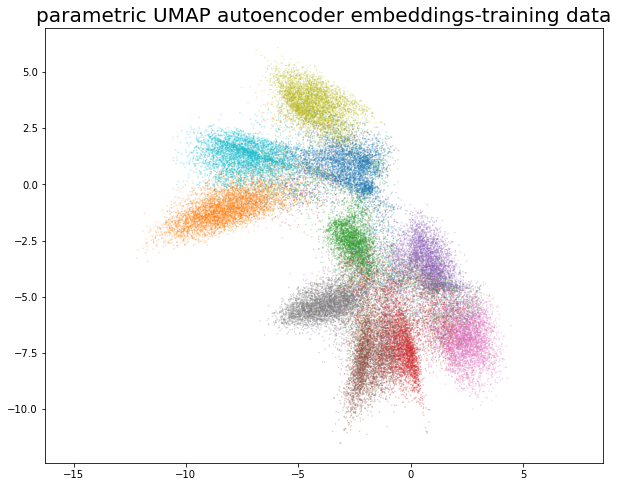

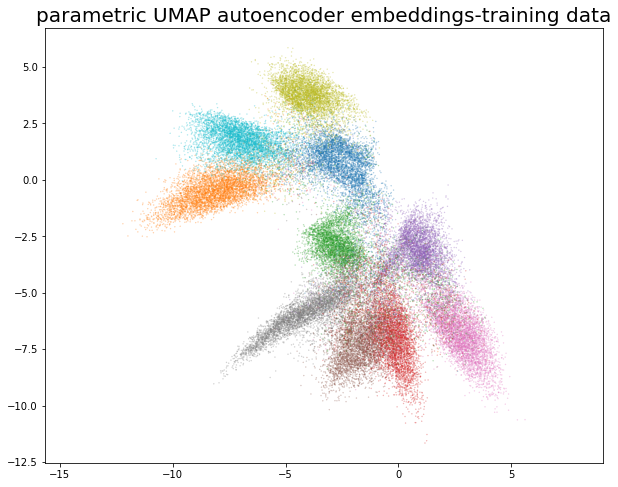

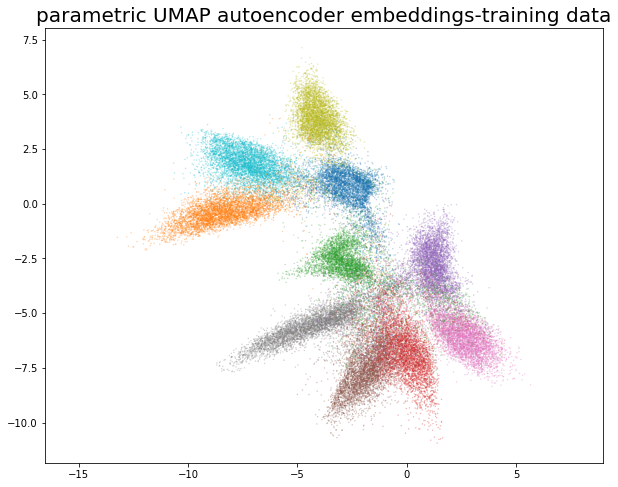

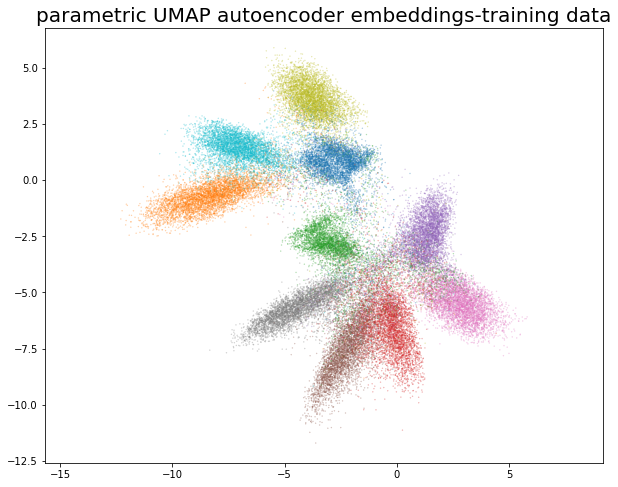

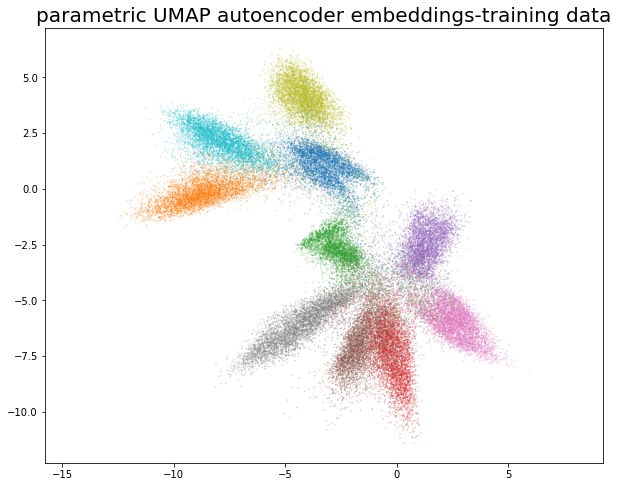

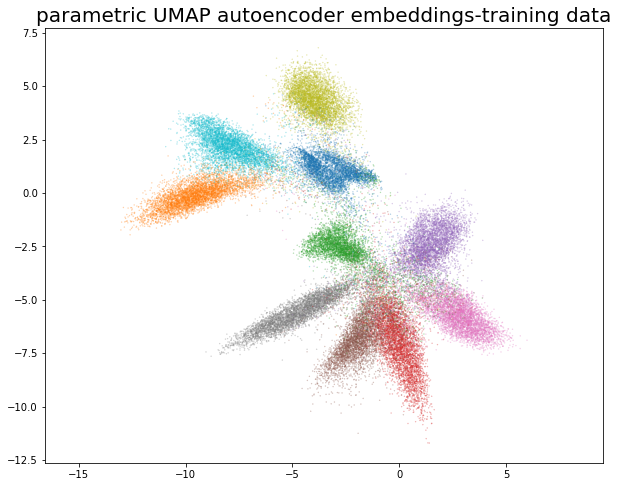

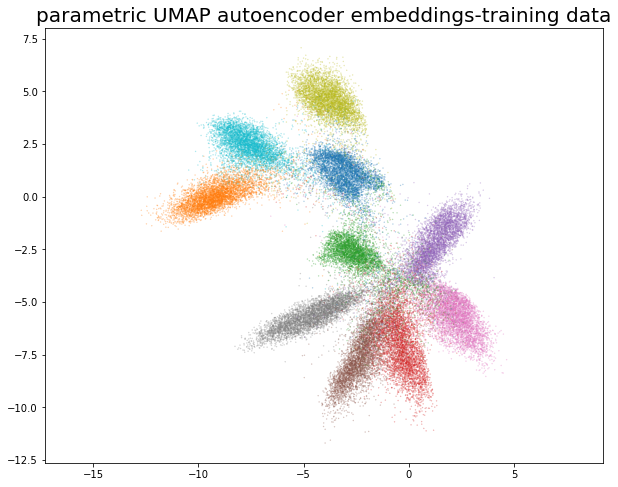

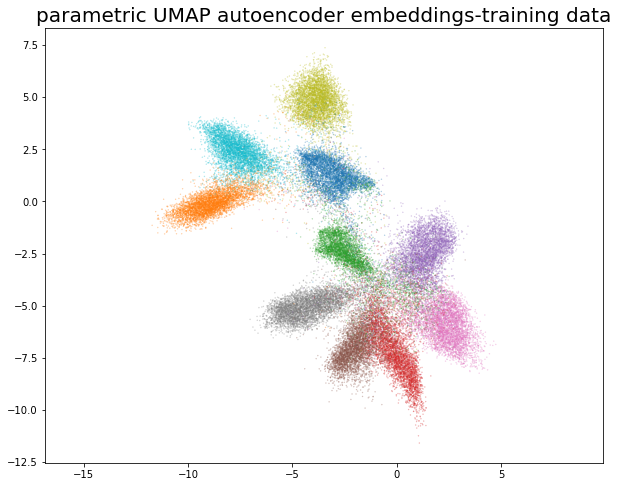

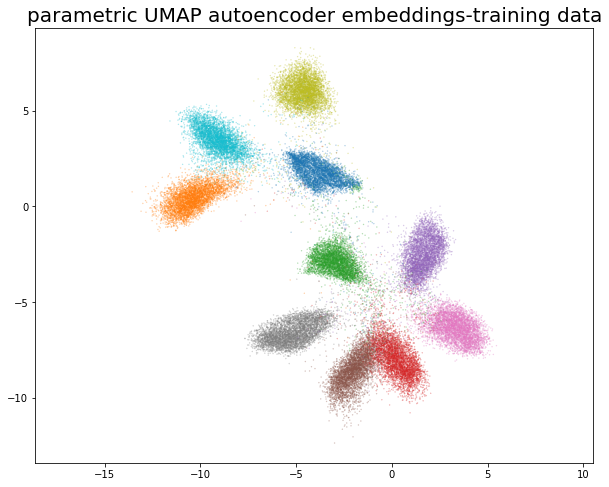

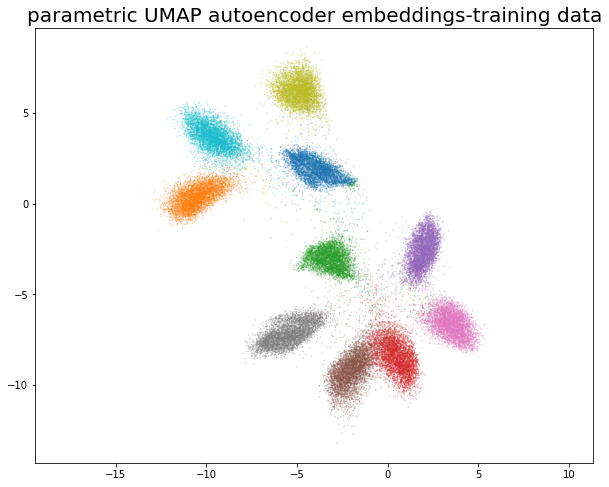

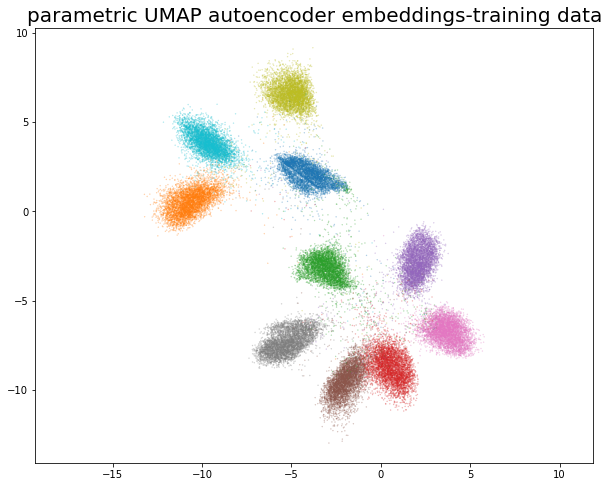

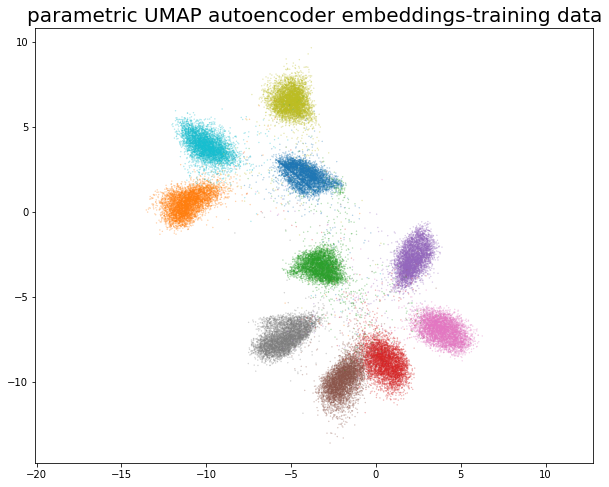

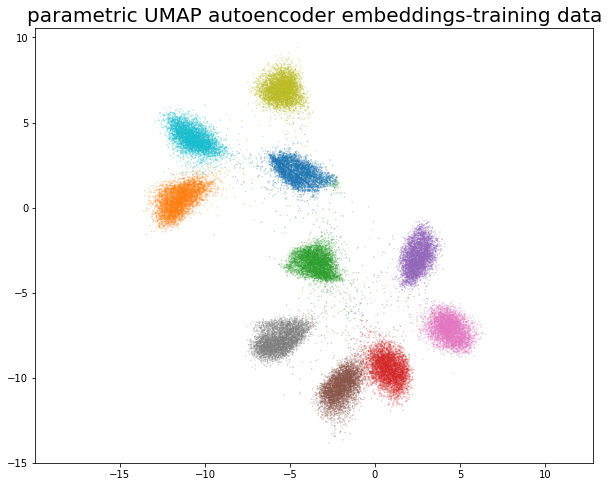

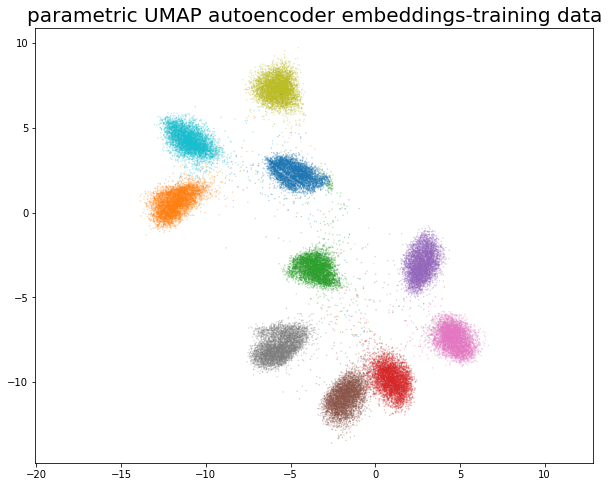

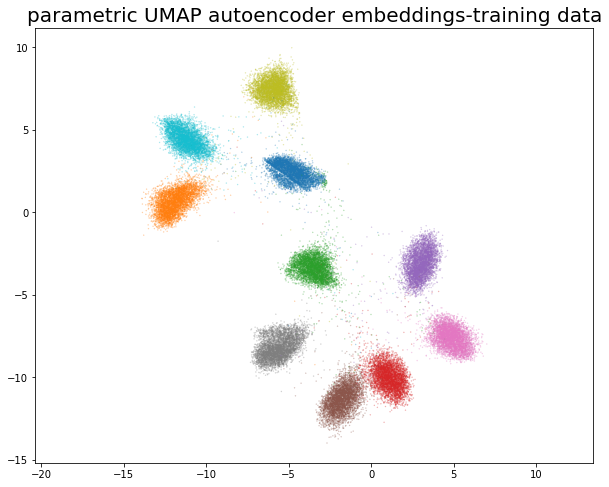

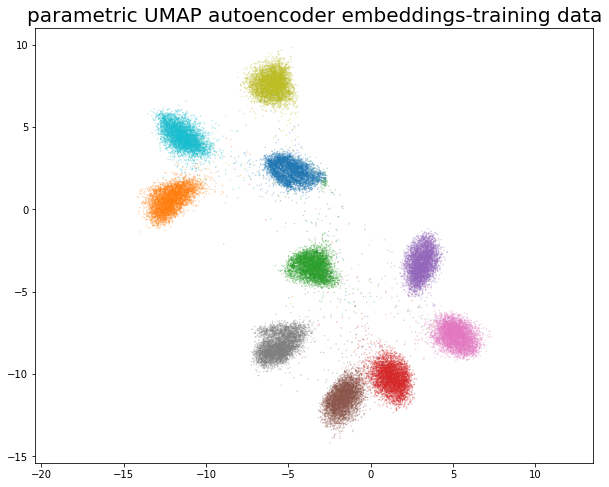

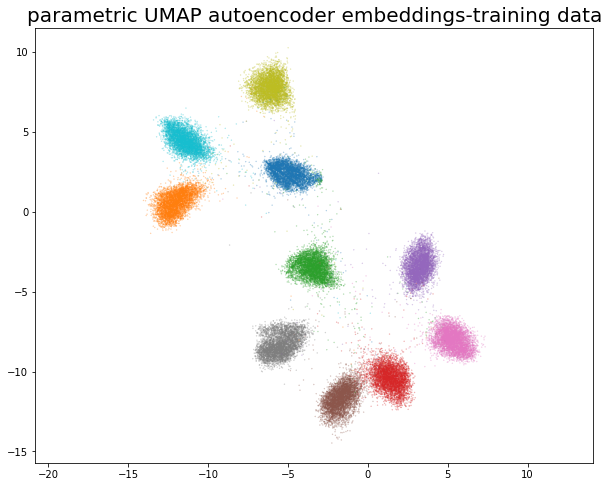

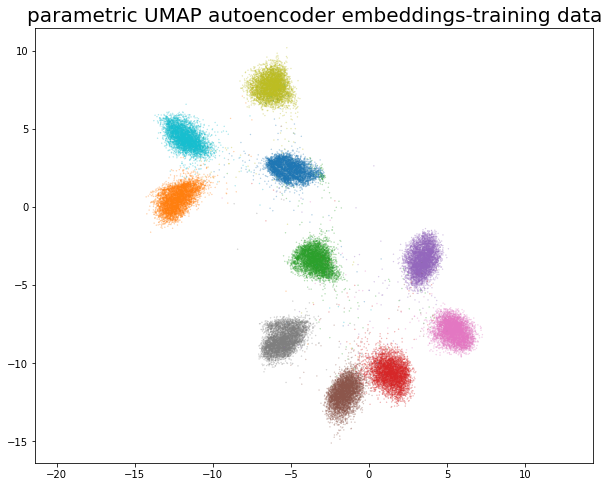

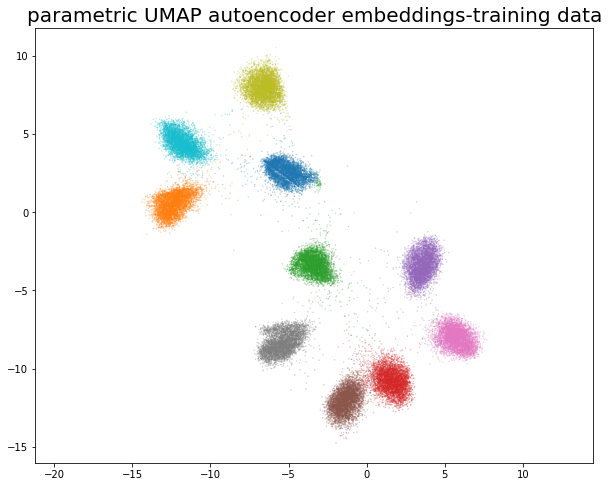

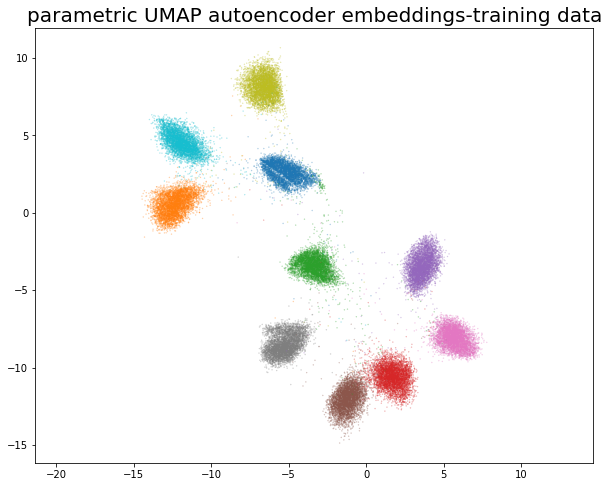

In [17]:
import matplotlib.pyplot as plt

data_dir = os.path.join(os.getcwd(),'high_output')
save_location = "parametric_umap_models\\ResNet56v1\\"
if not os.path.isdir(save_location):
    os.makedirs(save_location)
    
n_epoches = np.arange(10,210,10)
for n_epoch in n_epoches:
    datapath = os.path.join(data_dir,"train_{:03d}.npy".format(n_epoch))
    train_data = np.load(datapath)
    embedding = embedder.fit_transform(train_data)
    z = embedder.transform(train_data)
    
    # save encoder
    encoder_output = os.path.join(save_location, "encoder_{:03d}".format(n_epoch))
    embedder.encoder.save(encoder_output)
    print("Keras encoder model saved to {}".format(encoder_output))
    
    # save decoder
    decoder_output = os.path.join(save_location, "decoder_{:03d}".format(n_epoch))
    embedder.decoder.save(decoder_output)
    print("Keras decoder model saved to {}".format(decoder_output))

    fig, ax = plt.subplots(ncols=1, figsize=(10, 8))
    sc = ax.scatter(
        z[:, 0],
        z[:, 1],
        c=np.argmax(y_train, axis=1),
        cmap="tab10",
        s=0.1,
        alpha=0.5,
        rasterized=True,
    )
    ax.axis('equal')
    ax.set_title("parametric UMAP autoencoder embeddings-training data", fontsize=20)
    fig.savefig("result/evaluation/parametricUmap/train_{:03d}".format(n_epoch))

50/50 [==============================] - 0s 1ms/step


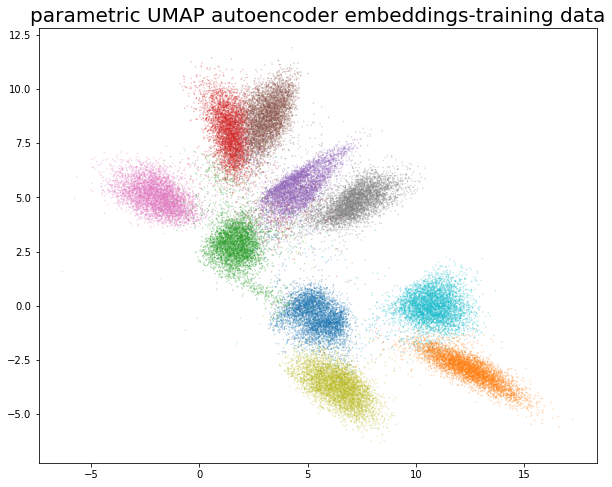

In [13]:
# example
import matplotlib.pyplot as plt
# Project data
z = embedder.transform(train_data)
# z = load_encoder(train_data)

fig, ax = plt.subplots(ncols=1, figsize=(10, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=np.argmax(y_train, axis=1),
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("parametric UMAP autoencoder embeddings-training data", fontsize=20)
fig.savefig("result/evaluation/parametricUmap/train_{:03d}".format(n_epoch))

In [18]:
from deepview import DeepView
# remember to reset embedder
save_location = "parametric_umap_models\\ResNet56v1\\"
if not os.path.isdir(save_location):
    os.makedirs(save_location)
    
data_dir = os.path.join(os.getcwd(),'high_output')
n_epoches = np.arange(10,210,10)

for n_epoch in n_epoches:
    datapath = os.path.join(data_dir,"train_{:03d}.npy".format(n_epoch))
    train_data = np.load(datapath)
    
    embedding = embedder.fit_transform(train_data)
    
    # save encoder
    encoder_output = os.path.join(save_location, "encoder_{:03d}".format(n_epoch))
    embedder.encoder.save(encoder_output)
    print("Keras encoder model saved to {}".format(encoder_output))
    
    # save decoder
    decoder_output = os.path.join(save_location, "decoder_{:03d}".format(n_epoch))
    embedder.decoder.save(decoder_output)
    print("Keras decoder model saved to {}".format(decoder_output))


    # ---------------------load dataset------------------------------

    def pred_wrapper(x):
        model_name = 'cifar10_ResNet56v1_model.{:03d}.h5'.format(n_epoch)
        modelpath = os.path.join(os.path.join(os.getcwd(), 'resnet_models'), model_name)
        load_model = tf.keras.models.load_model(modelpath)
        
        #load fully connect layer
        fc_input = tf.keras.layers.Input(shape=(64,))
        logits = fc_input
        logits = load_model.get_layer("dense")(logits)
        fc_model = Model(inputs=fc_input,outputs=logits)
        

        output = fc_model(x)
        probabilities = tf.nn.softmax(output,axis=-1).cpu().numpy()
        return probabilities

    def visualization(image, point2d, pred, label=None, title=None):
        f, a = plt.subplots()
        a.set_title(title)
        a.imshow(image.transpose([1, 2, 0]))

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # ---------------------deepview------------------------------
    batch_size = 200
    max_samples = 50000
    data_shape = (2048,)
    n = 5
    lam = 0
    resolution = 100
    cmap = 'tab10'
    title = 'ResNet-56 - CIFAR10 GAP layer-parametric umap autoencoder'

    deepview = DeepView(pred_wrapper, classes, max_samples, batch_size,
                        data_shape, n, lam, resolution, cmap, title=title, data_viz=visualization,
                        clip_certainty=1.2, metric="parametricUmap", encoder=embedder.encoder, decoder=embedder.decoder)


    deepview.add_samples(train_data, np.argmax(y_train, axis=1))
    deepview.savefig("result\\evaluation\\parametricUmap\\deepview_train_{:03d}.png".format(n_epoch))

ParametricUMAP(autoencoder_loss=True, batch_size=1000,
               decoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x00000247DFF52518>,
               dims=(64,),
               encoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x00000247DFF81CF8>,
               keras_fit_kwargs={'callbacks': [<tensorflow.python.keras.callbacks.EarlyStopping object at 0x00000247E0FAE390>,
                                               <tensorflow.python.keras.callbacks.TensorBoard object at 0x00000247E0FAEDA0>]},
               n_training_epochs=100,
               optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x00000247DFFBBB38>,
               parametric_reconstruction=True)
Construct fuzzy simplicial set
Thu Dec 17 01:00:55 2020 Finding Nearest Neighbors
Thu Dec 17 01:00:55 2020 Building RP forest with 16 trees
Thu Dec 17 01:00:56 2020 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold m

D:\xianglin\git_space\DeepVisualInsight\DeepView\parametric_umap.py:268: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  "Data should be scaled to the range 0-1 for cross-entropy reconstruction loss."


Epoch 1/1000
612/612 [==============================] - 6s 9ms/step - loss: 0.7064 - reconstruction_loss: 0.5027 - umap_loss: 0.2037
Epoch 2/1000
612/612 [==============================] - 5s 7ms/step - loss: 0.5293 - reconstruction_loss: 0.3440 - umap_loss: 0.1854
Epoch 3/1000
612/612 [==============================] - 5s 7ms/step - loss: 0.5142 - reconstruction_loss: 0.3318 - umap_loss: 0.1824
Epoch 4/1000
612/612 [==============================] - 5s 8ms/step - loss: 0.5065 - reconstruction_loss: 0.3260 - umap_loss: 0.1805
Epoch 5/1000
612/612 [==============================] - 5s 8ms/step - loss: 0.5016 - reconstruction_loss: 0.3220 - umap_loss: 0.1795A: 2s - loss: 0.5017 
Epoch 6/1000
612/612 [==============================] - 5s 8ms/step - loss: 0.4982 - reconstruction_loss: 0.3196 - umap_loss: 0.1786
Epoch 7/1000
612/612 [==============================] - 5s 8ms/step - loss: 0.4967 - reconstruction_loss: 0.3181 - umap_loss: 0.1786
Epoch 8/1000
612/612 [==========================

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 64 and the array at index 1 has size 2048

## compare the distance between high dimension data and low dimension data
k = high_dist / low_dist

In [ ]:
import pandas as pd
diff = pd.DataFrame(columns = ["epoches","max_dist","min_dist","mean_dist","median_dist","std_dist"])

In [ ]:
n_epoches = np.arange(2,36,2)
encoder_location = "parametric_umap_models\\ResNet56v1\\"

for n_epoch in n_epoches:
    datapath = os.path.join(data_dir,"train_{:03d}.npy".format(n_epoch))
    train_prev = np.load(datapath)
    datapath = os.path.join(data_dir,"train_{:03d}.npy".format(n_epoch+2))
    train_behind = np.load(datapath)
    
    # load encoder
    encoder_path = os.path.join(encoder_location, "encoder_{:03d}".format(n_epoch))
    encoder_prev = tf.keras.models.load_model(encoder_path)
    print("Keras encoder model loaded from {}".format(encoder_path))
    encoder_path = os.path.join(encoder_location, "encoder_{:03d}".format(n_epoch+2))
    encoder_behind = tf.keras.models.load_model(encoder_path)
    print("Keras encoder model loaded from {}".format(encoder_path))
    
    low_prev = encoder_prev(train_prev).cpu().numpy()
    low_behind = encoder_behind(train_behind).cpu().numpy()
    
    high_dist = np.linalg.norm(train_prev - train_behind,axis=1)
    low_dist = np.linalg.norm(low_prev - low_behind,axis=1)
    k = high_dist / low_dist
    
    max_k = k.max()
    min_k = k.min()
    mean_k = k.mean()
    median_k = np.median(k)
    std_k = k.std()
    epoch_num = "{:03d}/{:03d}".format(n_epoch,n_epoch+2)
    diff.loc[len(diff)] = [epoch_num, max_k, min_k,  mean_k, median_k,std_k]
diff

## print the result for each snapshot and draw a demo for it

Keras encoder model loaded from parametric_umap_models\ResNet56v1\encoder_010
Keras decoder model loaded from parametric_umap_models\ResNet56v1\decoder_010
Embedding samples ...
Computing decision regions ...


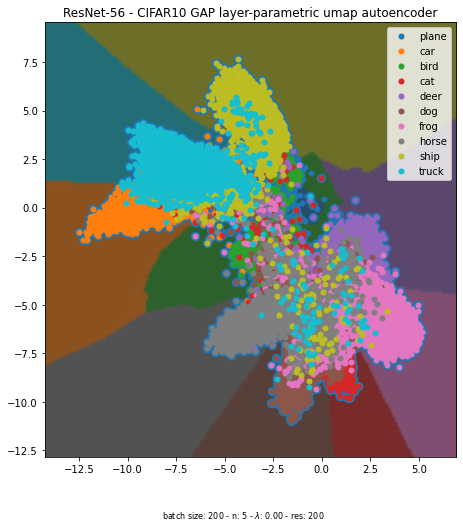

In [25]:
# using deepview
from deepview import DeepView
# remember to reset embedder
encoder_location = "parametric_umap_models\\ResNet56v1\\"
    
data_dir = os.path.join(os.getcwd(),'high_output')
n_epoches = np.arange(10,20,10)

for n_epoch in n_epoches:
    datapath = os.path.join(data_dir,"train_{:03d}.npy".format(n_epoch))
    train_data = np.load(datapath)
    
    # load encoder
    encoder_path = os.path.join(encoder_location, "encoder_{:03d}".format(n_epoch))
    encoder = tf.keras.models.load_model(encoder_path)
    print("Keras encoder model loaded from {}".format(encoder_path))
    # load decoder
    decoder_path = os.path.join(encoder_location, "decoder_{:03d}".format(n_epoch))
    decoder = tf.keras.models.load_model(decoder_path)
    print("Keras decoder model loaded from {}".format(decoder_path))


    # ---------------------load dataset------------------------------

    def pred_wrapper(x):
        model_name = 'cifar10_ResNet56v1_model.{:03d}.h5'.format(n_epoch)
        modelpath = os.path.join(os.path.join(os.getcwd(), 'resnet_models'), model_name)
        load_model = tf.keras.models.load_model(modelpath)
        
        #load fully connect layer
        fc_input = tf.keras.layers.Input(shape=(64,))
        logits = fc_input
        logits = load_model.get_layer("dense")(logits)
        fc_model = Model(inputs=fc_input,outputs=logits)
        
        output = fc_model(x)
        probabilities = tf.nn.softmax(output,axis=-1).cpu().numpy()
        return probabilities

    def visualization(image, point2d, pred, label=None, title=None):
        f, a = plt.subplots()
        a.set_title(title)
        a.imshow(image.transpose([1, 2, 0]))

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # ---------------------deepview------------------------------
    batch_size = 200
    max_samples = 50000
    data_shape = (64,)
    n = 5
    lam = 0
    resolution = 200
    cmap = 'tab10'
    title = 'ResNet-56 - CIFAR10 GAP layer-parametric umap autoencoder'

    deepview = DeepView(pred_wrapper, classes, max_samples, batch_size,
                        data_shape, n, lam, resolution, cmap, title=title, data_viz=visualization,
                        clip_certainty=0.1, metric="parametricUmap", encoder=encoder, decoder=decoder)


    deepview.add_samples(train_data, np.argmax(y_train, axis=1))
    deepview.savefig("result\\evaluation\\parametricUmap\\deepview_train_{:03d}.png".format(n_epoch))

In [ ]:
data_dir = os.path.join(os.getcwd(),'high_output')
encoder_location = "parametric_umap_models\\ResNet56v1\\"

n_epoches = np.arange(10,210,10)
for n_epoch in n_epoches:
    datapath = os.path.join(data_dir,"train_{:03d}.npy".format(n_epoch))
    train_data = np.load(datapath)
    
    # load encoder
    encoder_path = os.path.join(encoder_location, "encoder_{:03d}".format(n_epoch))
    encoder = tf.keras.models.load_model(encoder_path)
    print("Keras encoder model loaded from {}".format(encoder_path))
    
    z=encoder(train_data)
#     ??? .cpu.numpy()
    print(type(z))

    fig, ax = plt.subplots(ncols=1, figsize=(10, 8))
    sc = ax.scatter(
        z[:, 0],
        z[:, 1],
        c=np.argmax(y_train, axis=1),
        cmap="tab10",
        s=0.1,
        alpha=0.5,
        rasterized=True,
    )
    ax.axis('equal')
    ax.set_title("parametric UMAP autoencoder embeddings-training data", fontsize=20)
    fig.savefig("result/evaluation/parametricUmap/train_{:03d}".format(n_epoch))